In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

%matplotlib inline

# use mpl style on github
mpl.rc_file("../src/eztao/viz/eztao.rc")

pd.set_option("display.max_columns", 999)

### 1. Bring Old Code Here

In [4]:
from math import ceil
import celerite
from eztao.ts.utils import add_season, downsample_byN, downsample_byTime
from eztao.carma.CARMATerm import DRW_term, CARMA_term, DHO_term

In [227]:
def downsample_byN(t, nObs, seed=None):
    """
    Randomly choose N data points from a given time series.

    Args:
        t (array(float)): Time stamps of the original time series.
        N (int): The number of entries in the final time series.

    Returns:
        A 1d array booleans indicating which data points to keep.
    """

    if seed is not None:
        rng = np.random.default_rng(seed=seed)
    else:
        rng = np.random.default_rng()

    # random choose index
    idx = np.arange(len(t))
    mask = np.zeros_like(idx, dtype=np.bool_)
    true_idx = rng.choice(idx, nObs, replace=False)

    # assign chosen index to 1/True
    mask[true_idx] = 1

    return mask

In [34]:
def gp_sample(gp, size=None, seed=None):

    if seed is not None:
        rng = np.random.default_rng(seed=seed)
    else:
        rng = np.random.default_rng()

    gp._recompute()
    if size is None:
        n = rng.standard_normal(len(gp._t))
    else:
        n = rng.standard_normal((len(gp._t), size))
    n = gp.solver.dot_L(n)
    if size is None:
        return gp.mean.get_value(gp._t) + n[:, 0]
    return gp.mean.get_value(gp._t)[None, :] + n.T

In [29]:
def gpSimFull(carmaTerm, SNR, duration, N, nLC=1, log_flux=True, seed=None):
    """
    Simulate CARMA time series using uniform sampling.

    Args:
        carmaTerm (object): An EzTao CARMA kernel.
        SNR (float): Signal-to-noise defined as ratio between CARMA RMS amplitude and
            the median of the measurement errors (simulated using log normal).
        duration (float): The duration of the simulated time series (default in days).
        N (int): The number of data points in the simulated time series.
        nLC (int, optional): Number of time series to simulate. Defaults to 1.
        log_flux (bool): Whether the flux/y values are in astronomical magnitude.
            This argument affects how errors are assigned. Defaults to True.

    Raises:
        RuntimeError: If the input CARMA term/model is not stable, thus cannot be
            solved by celerite.

    Returns:
        (array(float), array(float), array(float)): Time stamps (default in day), y
        values and measurement errors of the simulated time series.
    """

    assert isinstance(
        carmaTerm, celerite.celerite.terms.Term
    ), "carmaTerm must a celerite GP term"

    if (not isinstance(carmaTerm, DRW_term)) and (carmaTerm._arroots.real > 0).any():
        raise RuntimeError(
            "The covariance matrix of the provided CARMA term is not positive definite!"
        )

    if seed is not None:
        rng = np.random.default_rng(seed=seed)
    else:
        rng = np.random.default_rng()

    t = np.linspace(0, duration, N)
    noise = carmaTerm.get_rms_amp() / SNR
    yerr = rng.lognormal(0, 0.25, N) * noise
    yerr = yerr[np.argsort(np.abs(yerr))]  # small->large

    # init GP and solve matrix
    gp_sim = GP(carmaTerm)
    gp_sim.compute(t)

    # simulate, assign yerr based on y
    t = np.repeat(t[None, :], nLC, axis=0)
    y = gp_sample(gp_sim, size=nLC, seed=seed)

    # format yerr making it heteroscedastic
    yerr = np.repeat(yerr[None, :], nLC, axis=0)

    # if in mag, large value with large error; in flux, the opposite
    if log_flux:
        # ascending sort
        y_rank = y.argsort(axis=1).argsort(axis=1)
        yerr = np.array(list(map(lambda x, y: x[y], yerr, y_rank)))
    else:
        # descending sort
        y_rank = (-y).argsort(axis=1).argsort(axis=1)
        yerr = np.array(list(map(lambda x, y: x[y], yerr, y_rank)))

    if nLC == 1:
        return t[0], y[0], yerr[0]
    else:
        return t, y, yerr

In [231]:
def gpSimRand(
    carmaTerm,
    SNR,
    duration,
    N,
    nLC=1,
    log_flux=True,
    season=True,
    full_N=10_000,
    lc_seed=None,
    downsample_seed=None,
):
    """
    Simulate CARMA time series randomly downsampled from a much denser full time series.

    Args:
        carmaTerm (object): An EzTao CARMA kernel.
        SNR (float): Signal-to-noise defined as ratio between CARMA RMS amplitude and
            the median of the measurement errors (simulated using log normal).
        duration (float): The duration of the simulated time series (default in days).
        N (int): The number of data points in the simulated time series.
        nLC (int, optional): Number of time series to simulate. Defaults to 1.
        log_flux (bool): Whether the flux/y values are in astronomical magnitude.
            This argument affects how errors are assigned. Defaults to True.
        season (bool, optional): Whether to simulate 6-months seasonal gaps. Defaults
            to True.
        full_N (int, optional): The number of data points in the full time series
            (before downsampling). Defaults to 10_000.

    Returns:
        (array(float), array(float), array(float)): Time stamps (default in day), y
        values and measurement errors of the simulated time series.
    """
    t, y, yerr = gpSimFull(
        carmaTerm, SNR, duration, full_N, nLC=nLC, log_flux=log_flux, seed=lc_seed
    )
    t = np.atleast_2d(t)
    y = np.atleast_2d(y)
    yerr = np.atleast_2d(yerr)

    # output t & yerr
    tOut = np.empty((nLC, N))
    yOut = np.empty((nLC, N))
    yerrOut = np.empty((nLC, N))

    # downsample
    for i in range(nLC):
        if season:
            mask1 = add_season(t[i])
        else:
            mask1 = np.ones(t[i].shape[0], dtype=bool)
        mask2 = downsample_byN(t[i, mask1], N, seed=downsample_seed)
        tOut[i, :] = t[i, mask1][mask2]
        yOut[i, :] = y[i, mask1][mask2]
        yerrOut[i, :] = yerr[i, mask1][mask2]

    if nLC == 1:
        return tOut[0], yOut[0], yerrOut[0]
    else:
        return tOut, yOut, yerrOut

In [61]:
def gpSimByTime(carmaTerm, SNR, t, factor=10, nLC=1, log_flux=True, seed=None):
    """
    Simulate CARMA time series at desired time stamps.

    This function uses a 'factor' parameter to determine the sampling rate of a full
    time series to simulate and downsample from. For example, if 'factor' = 10, then
    the full time series will be 10 times denser than the median sampling rate of the
    provided time stamps.

    Args:
        carmaTerm (object): An EzTao CARMA kernel.
        SNR (float): Signal-to-noise defined as ratio between CARMA RMS amplitude and
            the median of the measurement errors (simulated using log normal).
        t (array(float)): The desired time stamps (starting from zero).
        factor (int, optional): Parameter to control the ratio in the sampling
            rate between the simulated full time series and the desired output one.
            Defaults to 10.
        nLC (int, optional): Number of time series to simulate. Defaults to 1.
        log_flux (bool): Whether the flux/y values are in astronomical magnitude.
            This argument affects how errors are assigned. Defaults to True.

    Returns:
        (array(float), array(float), array(float)): Time stamps (default in day), y
        values and measurement errors of the simulated time series.
    """
    # get number points in full LC based on desired cadence
    duration = ceil(t[-1] - t[0])
    N = int(factor * ceil(duration / np.median(t[1:] - t[:-1])))

    # simulate full LC
    tFull, yFull, yerrFull = gpSimFull(
        carmaTerm, SNR, duration, N=N, nLC=nLC, log_flux=log_flux, seed=seed
    )
    tFull = np.atleast_2d(tFull)
    yFull = np.atleast_2d(yFull)
    yerrFull = np.atleast_2d(yerrFull)

    # downsample by desired output cadence
    t_expand = np.repeat(t[None, :], nLC, axis=0)
    tOut_idx = np.array(list(map(downsample_byTime, tFull, t_expand)))
    tOut = np.array(list(map(lambda x, y: x[y], tFull, tOut_idx)))
    yOut = np.array(list(map(lambda x, y: x[y], yFull, tOut_idx)))
    yerrOut = np.array(list(map(lambda x, y: x[y], yerrFull, tOut_idx)))

    if nLC == 1:
        return tOut[0], yOut[0], yerrOut[0]
    else:
        return tOut, yOut, yerrOut

In [76]:
def addNoise(y, yerr, seed=None):
    """
    Add (gaussian) noise to the input simulated time series given the measurement uncertainties.

    Args:
        y (array(float)): The 'clean' time series.
        yerr (array(float)): The measurement uncertainties for the input
            time series.

    Returns:
        array(float): A new time series with simulated (gaussian ) noise added
        on top.
    """

    if seed is not None:
        rng = np.random.default_rng(seed=seed)
    else:
        rng = np.random.default_rng()

    vec_norm = np.vectorize(rng.normal, signature="(n),(n)->(n)")
    noise = vec_norm(np.zeros_like(y), yerr)

    return y + noise

### 2. Modify above & Test Below

#### 2.1 Create test DHO kernel 

In [160]:
# my DHO notation
logXi, logOmega0, logPerturb, logb0 = 0.8, -1.6, 1, -2.5

# carma notation
loga1 = logXi + logOmega0 + np.log10(2)
loga2 = 2 * logOmega0
logb1 = logb0 + logPerturb

# in DHO params in log10
print("In log10:")
print([loga1, loga2, logb0, logb1])

print("In log:")
loga1, loga2, logb0, logb1 = np.array([loga1, loga2, logb0, logb1]) * log10
print([loga1, loga2, logb0, logb1])

In log10:
[-0.49897000433601885, -3.2, -2.5, -1.5]
In log:
[-1.1489208938352915, -7.368272297580948, -5.756462732485115, -3.453877639491069]


In [143]:
dho_kernel = DHO_term(loga1, loga2, logb0, logb1)
print(f"RMS Amp: {dho_kernel.get_rms_amp()}")

RMS Amp: 0.1630257444736889


#### 2.1 `gpSimFull`

Text(0.5, 1.0, 'No seed')

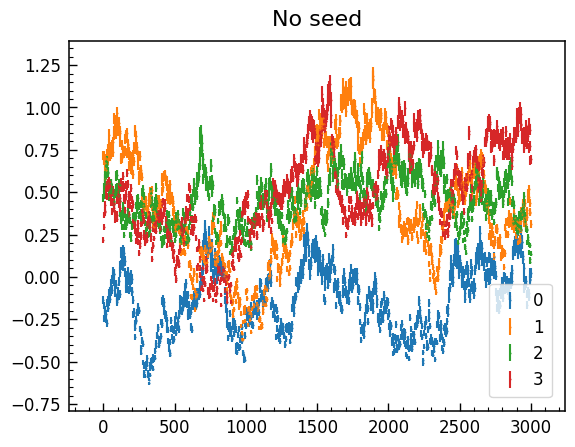

In [39]:
for i in range(4):
    t, y, yerr = gpSimFull(dho_kernel, 10, 3000, 1000)
    plt.errorbar(t, y + i * 0.2, yerr, fmt=".", label=i, markersize=1)

plt.legend(markerscale=1)
plt.title("No seed")

Text(0.5, 1.0, 'With seed')

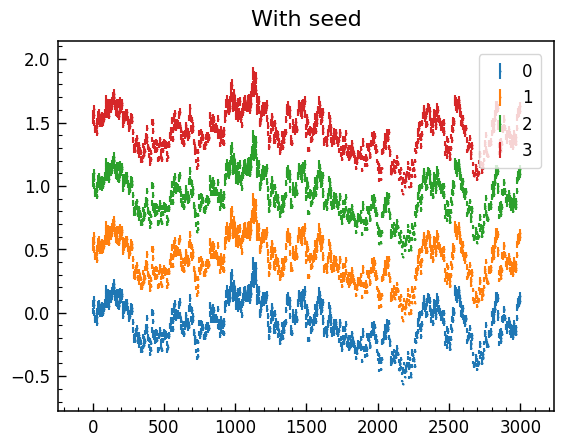

In [38]:
for i in range(4):
    t, y, yerr = gpSimFull(dho_kernel, 10, 3000, 1000, seed=42)
    plt.errorbar(t, y + i * 0.5, yerr, fmt=".", label=i, markersize=1)

plt.legend(markerscale=1)
plt.title("With seed")

#### 2.2 `gpSimRand`

Text(0.5, 1.0, 'No seed')

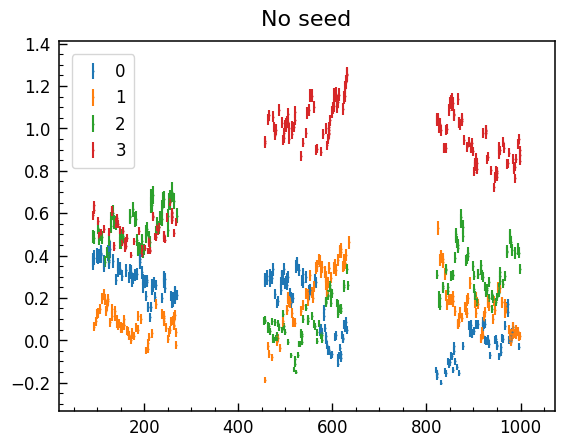

In [60]:
for i in range(4):
    t, y, yerr = gpSimRand(dho_kernel, 10, 1000, 200, nLC=2)
    plt.errorbar(t[0], y[0] + i * 0.2, yerr[0], fmt=".", label=i, markersize=1)

plt.legend(markerscale=1)
plt.title("No seed")

Text(0.5, 1.0, 'With seed')

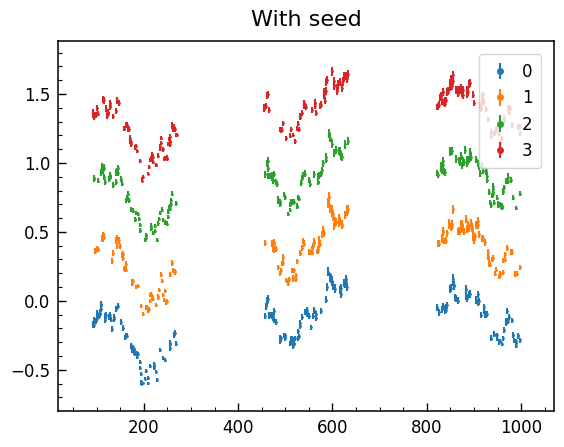

In [58]:
for i in range(4):
    t, y, yerr = gpSimRand(dho_kernel, 10, 1000, 200, seed=42)
    plt.errorbar(t, y + i * 0.5, yerr, fmt=".", label=i, markersize=2)

plt.legend(markerscale=4)
plt.title("With seed")

#### 2.3 `gpSimByTime`

Text(0.5, 1.0, 'No seed')

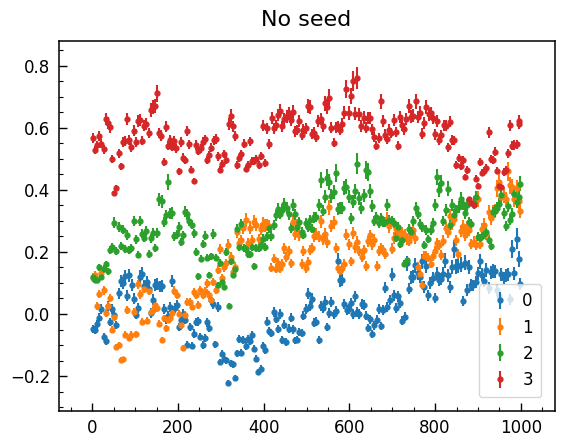

In [144]:
t = np.linspace(1, 1000, 200)
for i in range(4):
    t, y, yerr = gpSimByTime(dho_kernel, 10, t)
    plt.errorbar(t, y + i * 0.2, yerr, fmt=".", label=i, markersize=7)

plt.legend(markerscale=1)
plt.title("No seed")

Text(0.5, 1.0, 'No seed')

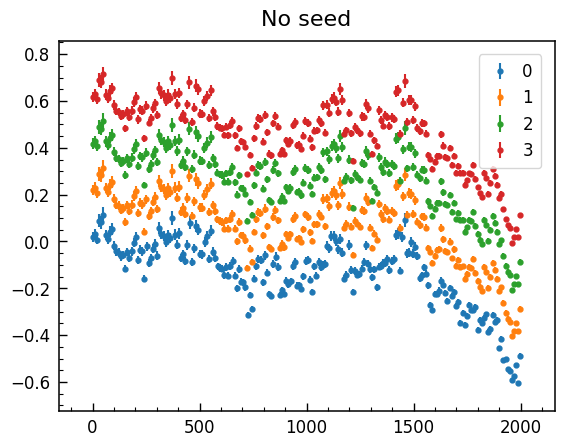

In [145]:
t = np.linspace(1, 2000, 200)
for i in range(4):
    t, y, yerr = gpSimByTime(dho_kernel, 10, t, seed=42)
    plt.errorbar(t, y + i * 0.2, yerr, fmt=".", label=i, markersize=7)

plt.legend(markerscale=1)
plt.title("No seed")

#### 2.4 `AddNoise`

Text(0.5, 1.0, 'No seed')

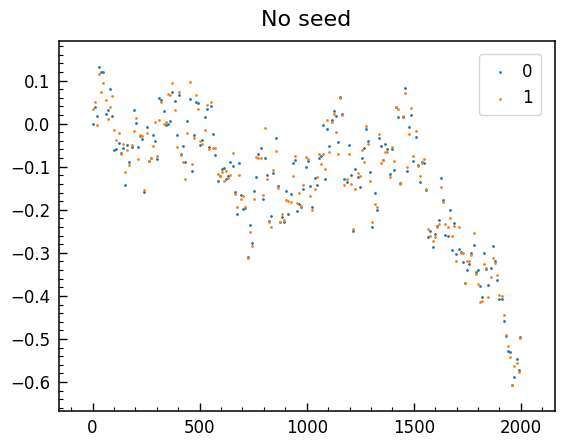

In [146]:
for i in range(2):
    y_noisy = addNoise(y, yerr)
    plt.scatter(t, y_noisy, s=1, label=i)

plt.legend(markerscale=1)

plt.title("No seed")

Text(0.5, 1.0, 'With seed')

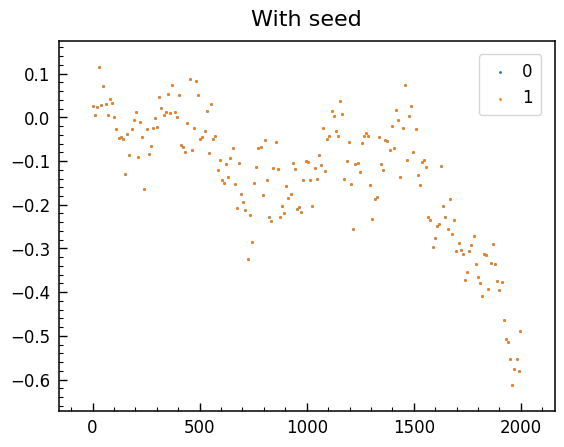

In [147]:
for i in range(2):
    y_noisy = addNoise(y, yerr, seed=42)
    plt.scatter(t, y_noisy, s=1, label=i)

plt.legend(markerscale=1)

plt.title("With seed")

### 3.0 Simulate Real AGN LC example
1. Param scales with $\lambda$
2. Add lag between bands, where the lag also scales with $\lambda$

**Note:** The default DHO param is assumed to be from g-band

In [205]:
lsst_lambda_eff = {"u": 360, "g": 480, "r": 620, "i": 750, "z": 870, "y": 1020}
annualN = {"u": 5, "g": 8, "r": 18, "i": 18, "z": 16, "y": 16}
yerr_md = {"u": 0.02, "g": 0.01, "r": 0.01, "i": 0.01, "z": 0.015, "y": 0.02}
amp_scale = -0.65
b0_scale = -1.1
xi_scale = 0.51
lag_scale = 4 / 3

In [192]:
def dho2carma(xi, b0, perturb, amp):

    # derive omega_0
    poly = [2 * (amp / b0) ** 2 * xi, -((perturb) ** 2), 0, -1]
    roots = np.roots(poly)
    omega_0 = np.abs(roots[0])

    # my dho notation to carma notation
    a1 = 2 * xi * omega_0
    a2 = omega_0**2
    b1 = b0 * perturb

    return a1, a2, b0, b1

##### Verify the `dho2carma` func

In [186]:
# my DHO notation
log10Xi, log10Omega0, log10Perturb, log10b0 = 0.8, -1.6, 1, -2.5
log10Amp = np.log10(dho_kernel.get_rms_amp())

# verify func dho2carma
print(
    np.log(dho2carma(10**log10Xi, 10**log10b0, 10**log10Perturb, 10**log10Amp))
)
print(loga1, loga2, logb0, logb1)

[-1.14892089 -7.3682723  -5.75646273 -3.45387764]
-1.1489208938352915 -7.368272297580948 -5.756462732485115 -3.453877639491069


#### 3.1 Create scaled DHO params in other bands

In [239]:
a1, a2, b0, b1 = {}, {}, {}, {}
for b in "ugrizy":
    lambda_diff = np.log10(lsst_lambda_eff[b] / lsst_lambda_eff["g"])
    new_log10Xi = xi_scale * lambda_diff + (log10Xi)
    new_log10b0 = b0_scale * lambda_diff + (log10b0)
    new_log10Amp = amp_scale * lambda_diff + (log10Amp + 0.2)
    a1[b], a2[b], b0[b], b1[b] = dho2carma(
        10**new_log10Xi, 10**new_log10b0, 10**log10Perturb, 10**new_log10Amp
    )

#### 3.2 Create lags & scale for each band

In [632]:
# radius at u-band in unit of time-day
lt_dist = {"u": 40}
for b in "grizy":
    lambda_diff = np.log10(lsst_lambda_eff[b] / lsst_lambda_eff["u"])
    lt_dist[b] = 10 ** (lambda_diff * lag_scale + np.log10(lt_dist["u"]))

In [633]:
lt_dist["y"] - lt_dist["g"]

101.66922749652254

#### 3.3 Simulated LCs

Text(0, 0.5, 'Magnitude')

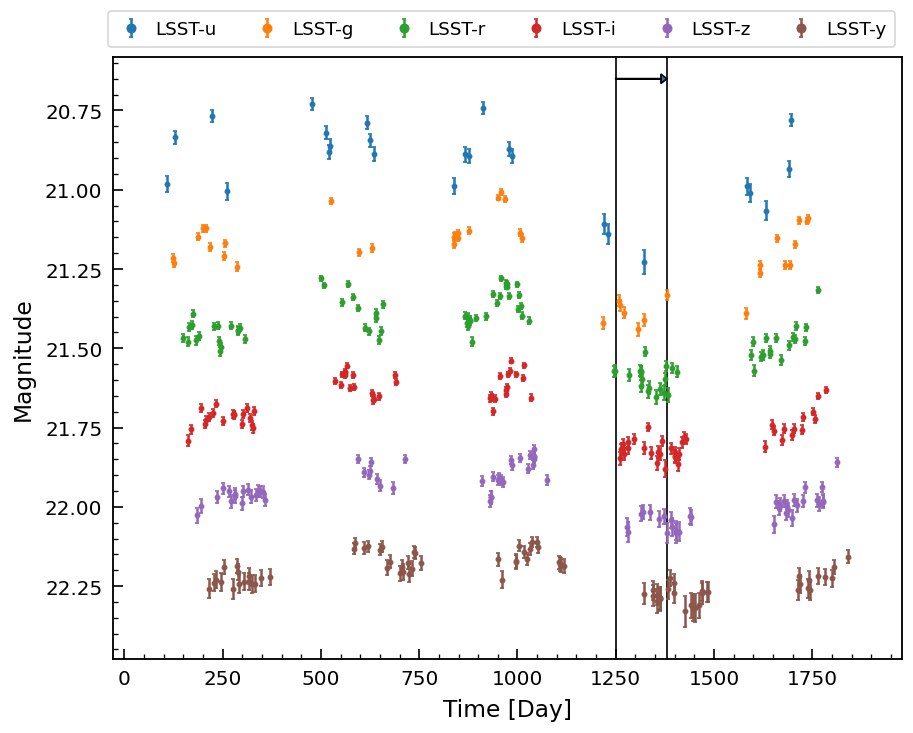

In [636]:
n_yr_sim = 5
shifts = {"u": 0.0, "g": 0.25, "r": 0.25, "i": 0.25, "z": 0.25, "y": 0.25}
shift = 0
fig = plt.figure(figsize=(7.5, 6), dpi=120, constrained_layout=True)
plt.ylim(20.58, 22.48)
for i, b in enumerate("ugrizy"):
    kernel = DHO_term(np.log(a1[b]), np.log(a2[b]), np.log(b0[b]), np.log(b1[b]))
    amp = kernel.get_rms_amp()

    # compute lag
    lag = lt_dist[b] - lt_dist["u"]
    # lag=0

    t, y, yerr = gpSimRand(
        kernel,
        amp / yerr_md[b],
        n_yr_sim * 365,
        n_yr_sim * annualN[b],
        lc_seed=42,
        downsample_seed=43 + i,
    )
    shift += shifts[b]
    plt.errorbar(
        t + lag * 1,
        21 + y + shift,
        yerr * 1.2,
        fmt=".",
        label=f"LSST-{b}",
        markersize=5,
        capthick=1,
        capsize=1,
    )

plt.legend(bbox_to_anchor=[1.01, 1.1], loc=1, markerscale=2, fontsize=11, ncol=6)

# vlines
ylim = plt.gca().get_ylim()
plt.vlines([1250, 1380], ymin=ylim[0], ymax=ylim[1], color="k", zorder=0, linewidth=1)
# plt.vlines(
#     [255, 1380],
#     ymin=ylim[0],
#     ymax=ylim[1],
#     color="k",
#     zorder=0,
#     linestyles=["--"],
#     linewidth=1,
# )

# lag arrow
# plt.arrow(
#     185,
#     20.65,
#     70,
#     0,
#     shape="full",
#     head_width=0.03,
#     head_length=15,
#     length_includes_head=True,
# )
plt.arrow(
    1250,
    20.65,
    130,
    0,
    shape="full",
    head_width=0.03,
    head_length=15,
    length_includes_head=True,
)

plt.gca().invert_yaxis()
plt.xlabel("Time [Day]")

plt.ylabel("Magnitude")

In [594]:
ts, ys, yerrs = {}, {}, {}

In [596]:
amps = {}

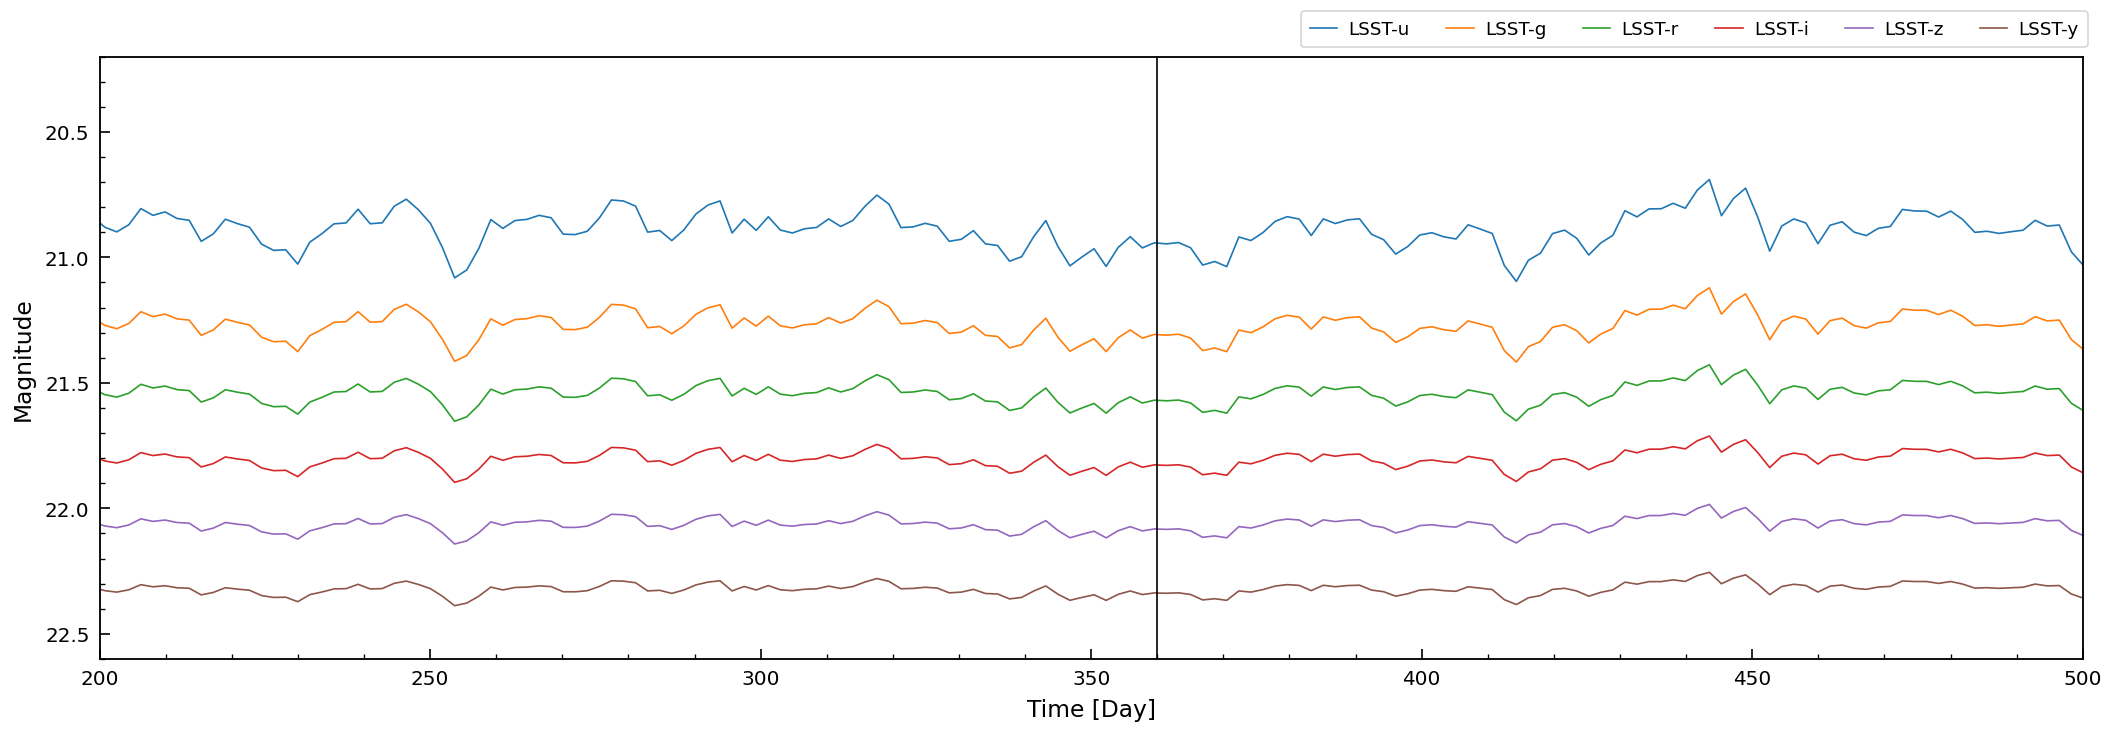

In [622]:
n_yr_sim = 50
shifts = {"u": 0.0, "g": 0.35, "r": 0.25, "i": 0.25, "z": 0.25, "y": 0.25}
shift = 0
fig = plt.figure(figsize=(17.5, 6), dpi=120, constrained_layout=True)
plt.ylim(20.2, 22.6)
for i, b in enumerate("ugrizy"):
    kernel = DHO_term(np.log(a1[b]), np.log(a2[b]), np.log(b0[b]), np.log(b1[b]))
    amp = kernel.get_rms_amp()
    amps[b] = amp
    # compute lag
    lag = lt_dist[b] - lt_dist["u"]
    # lag=0

    t, y, yerr = gpSimFull(
        kernel,
        amp * 10 / yerr_md[b],
        n_yr_sim * 365,
        # n_yr_sim * annualN[b],
        10000,
        seed=42,
        # downsample_seed=43 + i,
        # season=False,
        # full_N=100000,
    )
    ts[b] = t
    ys[b] = y
    yerrs[b] = yerr
    shift += shifts[b]
    plt.plot(
        t + lag * 0,
        21 + y + shift * 1,
        # yerr * 1.2,
        # fmt=".",
        label=f"LSST-{b}",
        linewidth=1
        # markersize=1,
        # capthick=1,
        # capsize=1,
    )

plt.legend(bbox_to_anchor=[1.01, 1.1], loc=1, markerscale=2, fontsize=11, ncol=6)

# # vlines
ylim = plt.gca().get_ylim()

# plt.vlines(
#     [2485, 2520],
#     ymin=ylim[0],
#     ymax=ylim[1],
#     color="k",
#     zorder=100,
#     linestyles=["--"],
#     linewidth=1,
# )

plt.gca().invert_yaxis()
plt.xlabel("Time [Day]")

plt.ylabel("Magnitude")
plt.xlim(200, 500)
plt.vlines([360], ymin=ylim[0], ymax=ylim[1], color="k", zorder=50, linewidth=1)

In [572]:
-1 / np.roots([1, a1["r"], a2["r"]])

array([  3.40819839, 697.79239685])

In [571]:
-1 / np.roots([1, a1["z"], a2["z"]])

array([  3.37017506, 977.61272279])

In [585]:
ys["g"] == ys["z"]

array([False, False, False, ..., False, False, False])

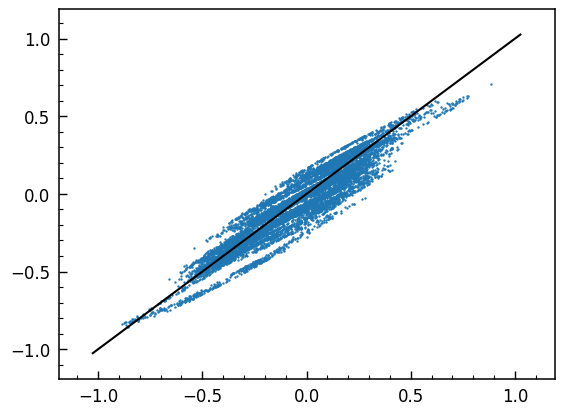

In [623]:
plt.scatter(ys["u"], ys["i"] * amps["u"] / amps["i"], s=0.5)
xlim = plt.gca().get_xlim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, x, color="k")

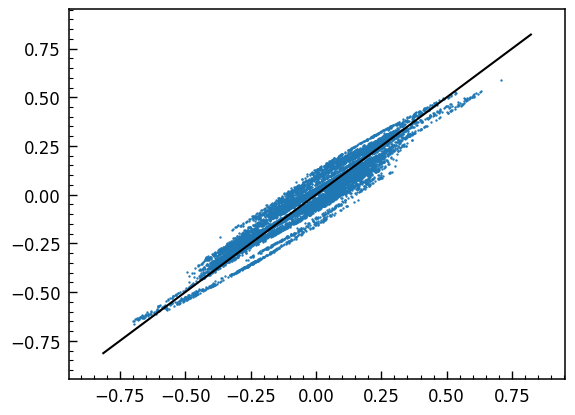

In [624]:
plt.scatter(
    ys["g"] - np.median(ys["g"]),
    (ys["z"] - np.median(ys["z"])) * amps["g"] / amps["z"],
    s=0.5,
)
xlim = plt.gca().get_xlim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, x, color="k")

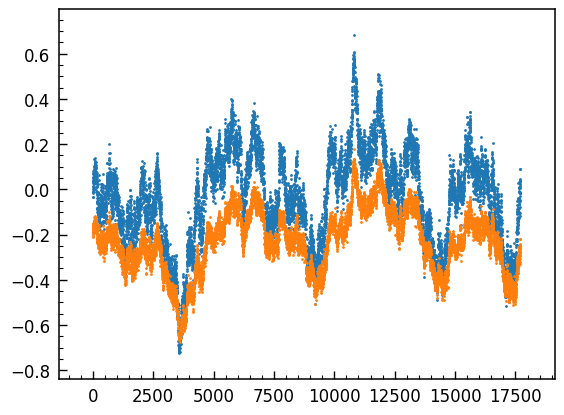

In [629]:
plt.scatter(ts["g"][:-300], ys["g"][:-300], s=1)
plt.scatter(ts["g"][:-300], -0.2 + ys["z"][:-300], s=1)

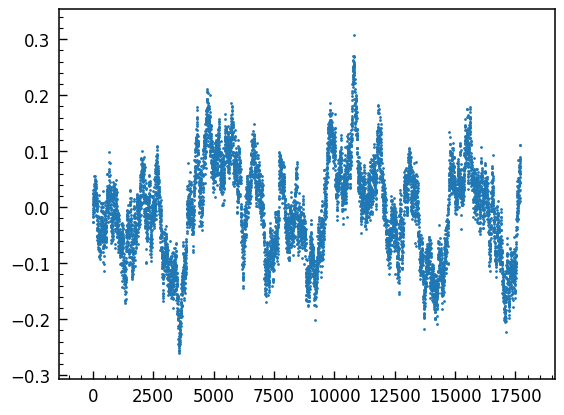

In [639]:
plt.scatter(ts["g"][:-300], ys["g"][:-300] - ys["z"][:-300], s=1)

In [646]:
ts['g'][300]

547.5547554755475

Text(0.5, 1.0, 'Color Variability (5-Day Lag)')

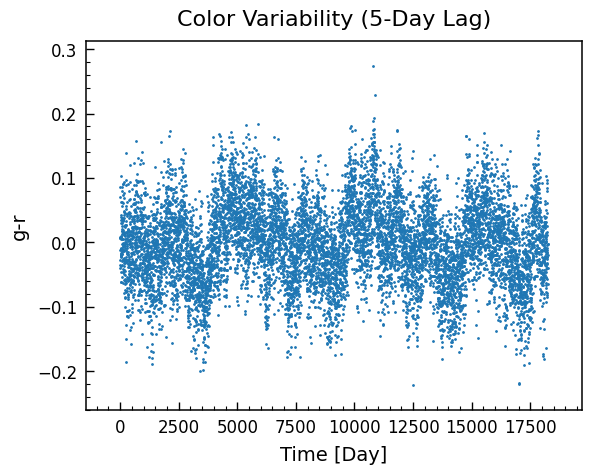

In [648]:
plt.scatter(ts["g"][:-3], ys["g"][:-3] - ys["r"][3:], s=1)

plt.xlabel("Time [Day]")
plt.ylabel("g-r")
plt.title("Color Variability (5-Day Lag)")

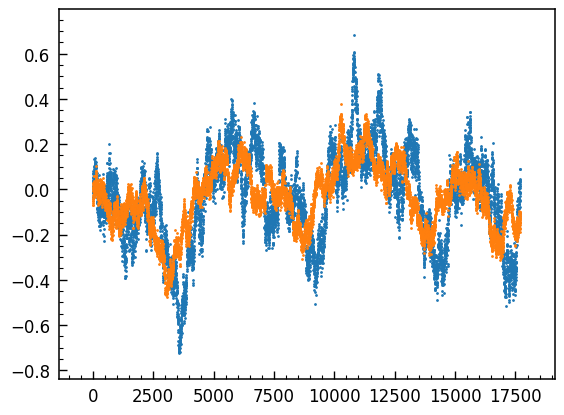

In [642]:
plt.scatter(ts["g"][:-300], ys["g"][:-300], s=1)
plt.scatter(ts["g"][:-300], ys["z"][300:], s=1)

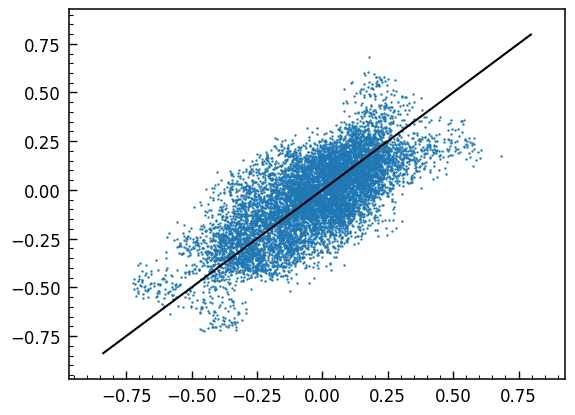

In [627]:
plt.scatter(ys["g"][:-100], ys["g"][100:], s=0.5)
xlim = plt.gca().get_xlim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, x, color="k")